In [1]:
import os
import pyautogui
import urllib.parse
import time
import pyperclip
import quopri
from bs4 import BeautifulSoup
from email import policy
from email.parser import BytesParser
import requests
import json
import pandas as pd

In [2]:
# simulate the operation
def auto_download(url,file_name):
    pyautogui.hotkey('ctrl', '2') # switch Google Chrome tabs
    time.sleep(0.5)
    
    pyautogui.click(207,55) # click the browser's address bar.
    time.sleep(0.5)
    
    pyautogui.hotkey('ctrl', 'a') # select all the content in address bar.
    pyperclip.copy(url) # copy the url from pyperclip
    time.sleep(0.5)
    
    pyautogui.hotkey('ctrl', 'v') # paste the url
    time.sleep(0.5)
    
    pyautogui.hotkey('enter') # access the url
    time.sleep(3)
    
    pyautogui.click(1910,1020)
    pyautogui.mouseDown() # scroll down the page to look through all guitars
    time.sleep(30)
    pyautogui.mouseUp()# release the left mouse button
    
    pyautogui.hotkey('ctrl', 's') # save the page to local path
    time.sleep(2)
    
    pyperclip.copy(file_name) # copy the file name
    pyautogui.hotkey('ctrl', 'v') # paste the file name
    time.sleep(2)
    
    pyautogui.hotkey('enter') # save the page with given name

In [3]:
# url for guitarcenter
base_url = "https://www.guitarcenter.com/6-String-Acoustic-Guitars.gc?N=1076+18154&Ns=bM&pageName=subcategory-page&recsPerPage=96&profileCountryCode=US&profileCurrencyCode=USD&SPA=true&Nao="

# download pages
def download_pages_guitarcenter(pages,step):
    for i in range(0,pages * step, step):
        url = base_url + str(i)
        auto_download(url, "guitar_" + str(int(i/step)))
        time.sleep(5)

download_pages_guitarcenter(44,96)

In [4]:
# parse the guitarcenter mhtml files
def parse_mhtml_guitarcenter(file_path):
    # Open the MHTML file in binary mode and parse it
    with open(file_path, 'rb') as file:
        msg = BytesParser(policy=policy.default).parse(file)

    # Decode the HTML part correctly
    html_part = None
    for part in msg.walk():
        content_type = part.get_content_type()
        if content_type == 'text/html':
            html_part = part.get_payload(decode=True)
            break

    charset = 'utf-8'
    decoded_html = html_part.decode(charset)

    # Use BeautifulSoup to parse the decoded HTML
    soup = BeautifulSoup(decoded_html, 'html.parser')
    
    # Get the div with the class of jsx-1611966181 flex flex-auto flex-wrap
    div = soup.find(class_="jsx-1611966181 flex flex-auto flex-wrap")

    # get the item list from that class
    item_list = div.find_all("section",class_="plp-product-grid py-[19px] md:p-1.5 flex flex-none flex-col md:flex-row md:border-none border-b border-solid border-[#BBBBBB] w-full md:w-1/2 lg:w-1/3 xl:w-1/4")
    
    return item_list

In [5]:
# extract the information of item
def instru_info_guitarcenter(item_list):
    # create a empty dictionary
    item_dict = {}

    for i in item_list:
        # image class
        img = i.find(class_ = "jsx-406435821 w-[264px] mt-5 md:mt-0")
        # title of guitar
        title = img.find_all("img")[1]["alt"]
        # url of guitar image
        imgurl = img.find_all("img")[1]["src"]
        # id for the guitar
        item_id = imgurl.split("/")[-1].split("-")[0]
        # price of guitar
        price = i.find(class_ = "jsx-2420341498 sale-price gc-font-bold text-[#2d2d2d]").text
        # location of the seller of the guitar
        if i.find(class_ = "jsx-3430979785 store-name-text"):
            location = i.find(class_ = "jsx-3430979785 store-name-text").text
        else:
            location = None
        # condition of the guitar
        condition = i.find(class_ = "jsx-3430979785 gc-font-light mb-2 text-xs").text.replace("Condition:","").strip()
        # add the info into dict
        item_dict[item_id] = {}
        item_dict[item_id]['image'] = imgurl
        item_dict[item_id]['title'] = title
        item_dict[item_id]['location'] = location
        item_dict[item_id]['price'] = price
        item_dict[item_id]['condition'] = condition
        
    return item_dict

In [6]:
# download the images
def image_download(info,path):
    for key,value in info.items():
        # download the image that does not exist
        if 'image_status' not in info[key]:
            # URL of the image
            image_url = value['image']
            # name of image
            file_name = key + ".jpg"
            # the download path
            save_path = os.path.join(path, file_name)
            # Send a GET request to the image URL
            response = requests.get(image_url)

            # Check if the request was successful
            if response.status_code == 200:
                with open(save_path, "wb") as file:
                    file.write(response.content)
                info[key]['image_status'] = 'Success'
            
            time.sleep(1.7)

In [7]:
# file path
path = 'D:/Study Abroad/course/CSE498/project/guitar_pages'

# info of electric guitar
guitarcenter_guitar_info = {}

# walk through all acoustic guitar files
for root, dirs, files in os.walk(path):
    for file in files:
        file_path = os.path.join(root, file)
        item_list = parse_mhtml_guitarcenter(file_path)
        item_dict = instru_info_guitarcenter(item_list)
        guitarcenter_guitar_info |= item_dict
        
# get the url of high-resolution images
for key,value in guitarcenter_guitar_info.items():
    guitarcenter_guitar_info[key]["image"] = guitarcenter_guitar_info[key]["image"].replace("264x264","600x600")

In [8]:
# download the high resolution acoustic guitar images
count = 0
path = 'D:/Study Abroad/course/CSE498/project/guitar_center_images'
while sum([int(bool(value.get("image_status",0))) for key,value in guitarcenter_guitar_info.items()]) < 4201:
    # handle errors related to unstable internet connection
    try:
        image_download(guitarcenter_guitar_info,path)
    except:
        count += 1
        print(f"retry {count}")
        time.sleep(120)

In [9]:
df = pd.DataFrame(guitarcenter_guitar_info).T

In [10]:
df.to_csv("D:/Study Abroad/course/CSE498/project/guitar_info.csv", index=True, index_label="index")

<Axes: title={'center': 'histogram'}, ylabel='Frequency'>

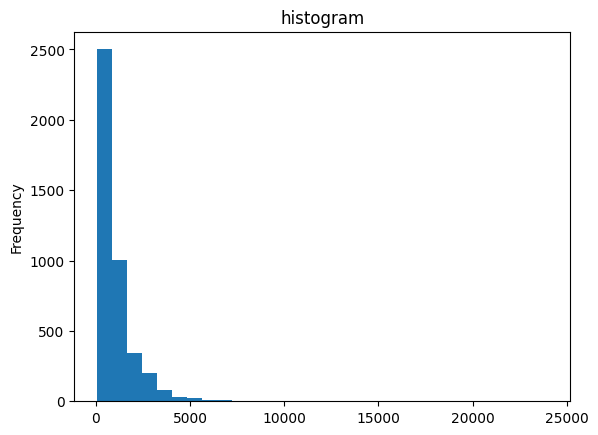

In [11]:
df["price"].apply(lambda x:float(x.replace("$","").replace(",",""))).plot(kind="hist",bins=30,title='histogram',xlabel='price')